# **Machine Learning Based Technique to predict  CPU-Burst Time**

In [1]:
import sqlite3
import numpy as np
import pandas as pd 
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,precision_score
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import os

## **1. Importing Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [5]:
!git init CPU\ Burst-Time\ Prediction

Reinitialized existing Git repository in /content/drive/MyDrive/Github/CPU Burst-Time Prediction/.git/


In [6]:
%cd CPU\ Burst-Time\ Prediction

/content/drive/MyDrive/Github/CPU Burst-Time Prediction


In [7]:
%ls -a

'CPU_BURST [FINAL].ipynb'   .git/


In [8]:
!git status 

On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   CPU_BURST [FINAL].ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [9]:
!git commit -m "first commit"


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@1dae22f7493c.(none)')


In [ ]:
username = 'PrathameshSamal123'
git_token = ''

In [ ]:
path = "/content/drive/MyDrive/DAS2.db3" 
cnx = sqlite3.connect(path)

df = pd.read_sql_query("SELECT * from Jobs ", cnx)

In [ ]:
df.head()

,JobID,SubmitTime,WaitTime,RunTime,NProc,UsedCPUTime,UsedMemory,ReqNProcs,ReqTime,ReqMemory,Status,UserID,GroupID,ExecutableID,QueueID,PartitionID,OrigSiteID,LastRunSiteID,JobStructure,JobStructureParams,UsedNetwork,UsedLocalDiskSpace,UsedResources,ReqPlatform,ReqNetwork,ReqLocalDiskSpace,ReqResources,VOID,ProjectID
0,1,1109087545,9,21,1,0.05,8282.112,1,-1.0,-1.0,1,U0,G0,X0,Q0,-1,DAS2/fs0,DAS2/fs0,UNITARY,-1,-1.0,-1.0,-1,-1,-1.0,-1.0,-1,-1,-1
1,2,1109087546,8,21,1,0.08,10485.760,1,-1.0,-1.0,1,U0,G0,X0,Q0,-1,DAS2/fs0,DAS2/fs0,UNITARY,-1,-1.0,-1.0,-1,-1,-1.0,-1.0,-1,-1,-1
2,3,1109087609,5,1,1,0.00,2584.576,1,-1.0,-1.0,1,U0,G0,X1,Q0,-1,DAS2/fs0,DAS2/fs0,UNITARY,-1,-1.0,-1.0,-1,-1,-1.0,-1.0,-1,-1,-1
3,4,1109091229,15,0,1,0.00,0.000,1,-1.0,-1.0,1,U0,G0,X1,Q0,-1,DAS2/fs0,DAS2/fs0,UNITARY,-1,-1.0,-1.0,-1,-1,-1.0,-1.0,-1,-1,-1
4,5,1109091214,65162,1,1,0.00,0.000,1,-1.0,-1.0,1,U0,G0,X1,Q0,-1,DAS2/fs0,DAS2/fs0,UNITARY,-1,-1.0,-1.0,-1,-1,-1.0,-1.0,-1,-1,-1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124772 entries, 0 to 1124771
Data columns (total 29 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   JobID               1124772 non-null  int64  
 1   SubmitTime          1124772 non-null  int64  
 2   WaitTime            1124772 non-null  int64  
 3   RunTime             1124772 non-null  int64  
 4   NProc               1124772 non-null  int64  
 5   UsedCPUTime         1124772 non-null  float64
 6   UsedMemory          1124772 non-null  float64
 7   ReqNProcs           1124772 non-null  int64  
 8   ReqTime             1124772 non-null  float64
 9   ReqMemory           1124772 non-null  float64
 10  Status              1124772 non-null  int64  
 11  UserID              1124772 non-null  object 
 12  GroupID             1124772 non-null  object 
 13  ExecutableID        1124772 non-null  object 
 14  QueueID             1124772 non-null  object 
 15  PartitionID    

In [ ]:
for col in df.columns[0:]:
    print(col,':',len(df[col].unique()),'labels')


JobID : 1124772 labels
SubmitTime : 826435 labels
WaitTime : 16274 labels
RunTime : 9597 labels
NProc : 81 labels
UsedCPUTime : 23560 labels
UsedMemory : 44582 labels
ReqNProcs : 81 labels
ReqTime : 255 labels
ReqMemory : 1 labels
Status : 2 labels
UserID : 333 labels
GroupID : 12 labels
ExecutableID : 9070 labels
QueueID : 3 labels
PartitionID : 1 labels
OrigSiteID : 5 labels
LastRunSiteID : 5 labels
JobStructure : 2 labels
JobStructureParams : 1957 labels
UsedNetwork : 1 labels
UsedLocalDiskSpace : 1 labels
UsedResources : 1 labels
ReqPlatform : 1 labels
ReqNetwork : 1 labels
ReqLocalDiskSpace : 1 labels
ReqResources : 1 labels
VOID : 1 labels
ProjectID : 1 labels


# **Feature Selection & Engineering**

## **1. Feature Filtering By Analysis**

In [ ]:
# df.drop(['ReqMemory','Status','QueueID','OrigSiteID','PartitionID','UsedNetwork','JobStructure','JobStructureParams',
#          'UsedLocalDiskSpace','UsedResources','ReqPlatform','ReqNetwork','ReqLocalDiskSpace','ReqResources','VOID','ProjectID',
#          'LastRunSiteID','SubmitTime'],axis=1,inplace=True)

# **Dropping Features with Constant Labels**

In [ ]:
columns_label1 = []
for col in df.columns[0:]:
  if len(df[col].unique())==1:
    columns_label1.append(col)


In [ ]:
# columns with len( label  ) = 1
columns_label1

['ReqMemory',
 'PartitionID',
 'UsedNetwork',
 'UsedLocalDiskSpace',
 'UsedResources',
 'ReqPlatform',
 'ReqNetwork',
 'ReqLocalDiskSpace',
 'ReqResources',
 'VOID',
 'ProjectID']

In [ ]:
df.drop(columns_label1,axis=1,inplace=True)

In [ ]:
df.head()

,JobID,SubmitTime,WaitTime,RunTime,NProc,UsedCPUTime,UsedMemory,ReqNProcs,ReqTime,Status,UserID,GroupID,ExecutableID,QueueID,OrigSiteID,LastRunSiteID,JobStructure,JobStructureParams
0,1,1109087545,9,21,1,0.05,8282.112,1,-1.0,1,U0,G0,X0,Q0,DAS2/fs0,DAS2/fs0,UNITARY,-1
1,2,1109087546,8,21,1,0.08,10485.760,1,-1.0,1,U0,G0,X0,Q0,DAS2/fs0,DAS2/fs0,UNITARY,-1
2,3,1109087609,5,1,1,0.00,2584.576,1,-1.0,1,U0,G0,X1,Q0,DAS2/fs0,DAS2/fs0,UNITARY,-1
3,4,1109091229,15,0,1,0.00,0.000,1,-1.0,1,U0,G0,X1,Q0,DAS2/fs0,DAS2/fs0,UNITARY,-1
4,5,1109091214,65162,1,1,0.00,0.000,1,-1.0,1,U0,G0,X1,Q0,DAS2/fs0,DAS2/fs0,UNITARY,-1


In [ ]:
### ONLY FOR KNN

# df.drop(['UserID','GroupID','ExecutableID','OrigSiteID','LastRunSiteID','JobStructure','QueueID'],inplace=True, axis=1)

In [ ]:
dfcopy = df.copy()

In [ ]:
sample_df = df.sample(n=30000,replace=True,random_state=5)

In [ ]:
X = sample_df.drop(['RunTime','JobID'],axis=1)
y = sample_df['RunTime']

In [ ]:
X.head()

,SubmitTime,WaitTime,NProc,UsedCPUTime,UsedMemory,ReqNProcs,ReqTime,Status,UserID,GroupID,ExecutableID,QueueID,OrigSiteID,LastRunSiteID,JobStructure,JobStructureParams
18638,1118226329,265,8,0.002500,1196.544,8,960.0,1,U38,G4,X17,Q0,DAS2/fs0,DAS2/fs0,UNITARY,-1
544751,1119848466,1001,1,56.000000,39788.544,1,900.0,1,U265,G3,X3432,Q0,DAS2/fs1,DAS2/fs1,UNITARY,-1
756710,1161894982,3,2,0.150000,15648.768,2,360.0,1,U66,G3,X14,Q0,DAS2/fs2,DAS2/fs2,UNITARY,-1
660880,1124929775,6,4,0.055000,9097.216,4,180.0,1,U66,G3,X14,Q0,DAS2/fs2,DAS2/fs2,UNITARY,-1
558088,1122909406,3,12,0.021667,2831.360,12,900.0,1,U69,G4,X14,Q0,DAS2/fs1,DAS2/fs1,UNITARY,-1


In [ ]:
test_cols = X.columns 
dtypes = []

for i in X.dtypes:
  dtypes.append(i)

In [ ]:
test_cols = pd.DataFrame(test_cols,columns=['Feature Name'])
test_cols.index = np.arange(1, len(test_cols)+1)

In [ ]:
X.dtypes
dtypes = ['int64','int64','int64','float64','float64','int64','float64','int64','object','object','object','object','object','object','object','object']


In [ ]:
test_cols['DataType'] = dtypes

In [ ]:
test_cols

,Feature Name,DataType
1,SubmitTime,int64
2,WaitTime,int64
3,NProc,int64
4,UsedCPUTime,float64
5,UsedMemory,float64
6,ReqNProcs,int64
7,ReqTime,float64
8,Status,int64
9,UserID,object
10,GroupID,object


## **Handling Categorical Data - Leave One Out Encoder**

In [ ]:
# !pip install category_encoders

In [ ]:
from category_encoders import LeaveOneOutEncoder
encoder = LeaveOneOutEncoder(return_df=True)

X = encoder.fit_transform(X, y)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
X.head()

,SubmitTime,WaitTime,NProc,UsedCPUTime,UsedMemory,ReqNProcs,ReqTime,Status,UserID,GroupID,ExecutableID,QueueID,OrigSiteID,LastRunSiteID,JobStructure,JobStructureParams
18638,1118226329,265,8,0.002500,1196.544,8,960.0,1,208.216495,163.703850,627.377543,372.924839,338.504008,338.504008,390.053283,390.053283
544751,1119848466,1001,1,56.000000,39788.544,1,900.0,1,123.893805,360.649792,372.864900,372.933642,261.542105,261.542105,390.063011,390.063011
756710,1161894982,3,2,0.150000,15648.768,2,360.0,1,264.907277,360.652386,268.607173,372.934743,208.783524,208.783524,390.064227,390.064227
660880,1124929775,6,4,0.055000,9097.216,4,180.0,1,264.896564,360.647826,268.603134,372.932809,208.768451,208.768451,390.062090,390.062090
558088,1122909406,3,12,0.021667,2831.360,12,900.0,1,46.452314,163.796150,268.610864,372.936510,261.572281,261.572281,390.066180,390.066180


# **M1: Feature Selection - chi2 Method**

In [ ]:
X_chi = X.copy()
y_chi = y.copy()
features = X.columns

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax_chi = min_max_scaler.fit_transform(X_chi)

In [ ]:
from sklearn.feature_selection import chi2,f_regression,mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

In [ ]:
best_features = SelectKBest(score_func=chi2,k=8)
fit = best_features.fit(X_minmax_chi,y_chi)
fit.scores_

array([6.98139212e+02, 1.92393709e+02, 5.10761133e+02, 4.26876290e+03,
       2.65509516e+03, 5.10761133e+02, 1.92821637e+03, 1.15201089e+01,
       9.04915663e+02, 8.09545198e+02, 1.62468123e+02, 5.63359087e-01,
       4.64693115e+02, 4.64693115e+02, 3.42663472e+02, 1.12680227e+02])

In [ ]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
featureScores.sort_values(by='Score',ascending=False)

,Feature,Score
3,UsedCPUTime,4268.762900
4,UsedMemory,2655.095158
6,ReqTime,1928.216371
8,UserID,904.915663
9,GroupID,809.545198
0,SubmitTime,698.139212
2,NProc,510.761133
5,ReqNProcs,510.761133
12,OrigSiteID,464.693115
13,LastRunSiteID,464.693115


In [ ]:
#  X.drop(['Status','WaitTime','JobStructure'],axis=1,inplace=True)
# MAIN
X.drop(['Status','QueueID','JobStructureParams','ExecutableID','WaitTime'],axis=1,inplace=True)
# X.drop(['Status','QueueID','JobStructureParams','ExecutableID','WaitTime','JobStructure'],axis=1,inplace=True)

# **ML Techniques**

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax,y,test_size=0.30,random_state=50)

## **XGBOOST**

In [ ]:
import xgboost as xg
from numpy import absolute
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score,log_loss

## **Default Parameters (Untuned)**

In [ ]:
  xgb_r = xg.XGBRegressor(objective ='reg:squarederror',seed = 123)   # default 
  xgb_r.fit(X_train, y_train)
  pred = xgb_r.predict(X_test)

In [ ]:
print('MAE:',mean_absolute_error(y_test,pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,pred)))
print('R2 Score:',r2_score(y_test,pred))


MAE: 36.14147055293454
RMSE 342.4302951424438
R2 Score: 0.9900284027664414


### **Test Data Vs Predicted Data**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


[]

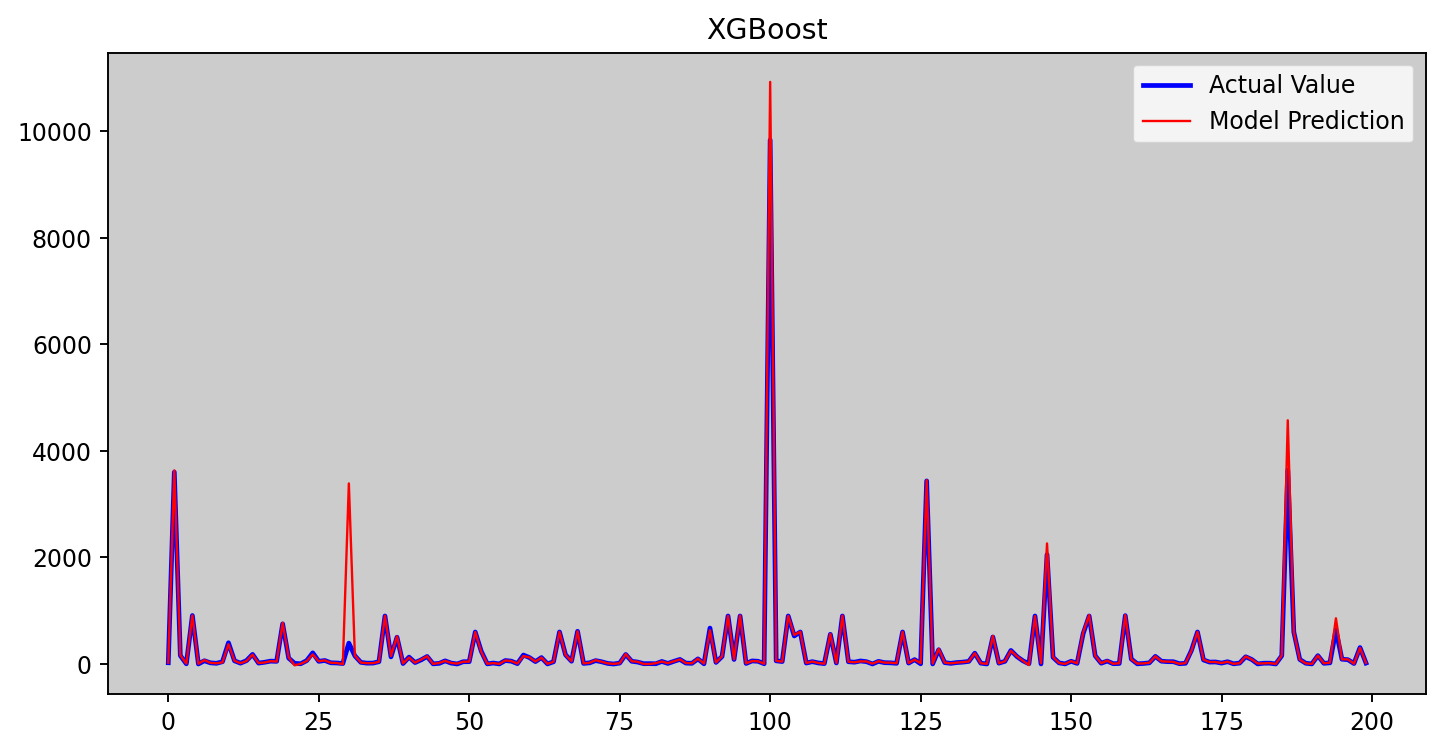

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

test = y_test.to_numpy().tolist()
predictions = pred.tolist()



figure(figsize=(10, 5), dpi=170)

plt.plot(test[0:200],'blue', label='Actual Value',linewidth=2)
plt.plot(predictions[0:200],'red',label='Model Prediction',linewidth=1)
plt.legend()
ax = plt.axes()
plt.title('XGBoost')
ax.set_facecolor("#cccccc")
plt.plot()

## **Parameter Tuning**

### PARAM TEST 1 : Max_Depth & Min_Child_Weight

In [ ]:
from xgboost.sklearn import XGBRegressor
param_test1 = {
 'max_depth':range(4,12,1),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

KeyboardInterrupt: ignored

In [ ]:
gsearch1.best_params_

{'max_depth': 4, 'min_child_weight': 1}

In [ ]:
# #XGBoost hyper-parameter tuning
# param_tuning = {
#         'learning_rate': [0.01, 0.1],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.5, 0.7],
#         'n_estimators' : [100, 200, 500, 700 , 800, 1000],
#         'objective': ['reg:squarederror']
#   }

# xgb_model = XGBRegressor()

# gsearch = GridSearchCV(estimator = xgb_model,
#                            param_grid = param_tuning,                        
#                            scoring = 'neg_mean_absolute_error', #MAE
#                           #  scoring = 'neg_mean_squared_error',  #MSE
#                            cv = 5,
#                            n_jobs = -1,
#                            verbose = 1)

# gsearch.fit(X_train,y_train)

# gsearch.best_params_

## **XGBOOST [Tuned]**

In [ ]:
  xgb_r = xg.XGBRegressor(objective ='reg:squarederror',colsample_bytree= 0.7,learning_rate= 0.1,subsample= 0.7,n_estimators= 1000,max_depth= 4,min_child_weight= 1,seed = 123)   # Tuned
  xgb_r.fit(X_train, y_train)
  pred = xgb_r.predict(X_test)

In [ ]:
print('MAE:',mean_absolute_error(y_test,pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,pred)))
print('R2 Score:',r2_score(y_test,pred))

MAE: 31.06844704772035
RMSE 432.5588648088285
R2 Score: 0.9840885117746211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


[]

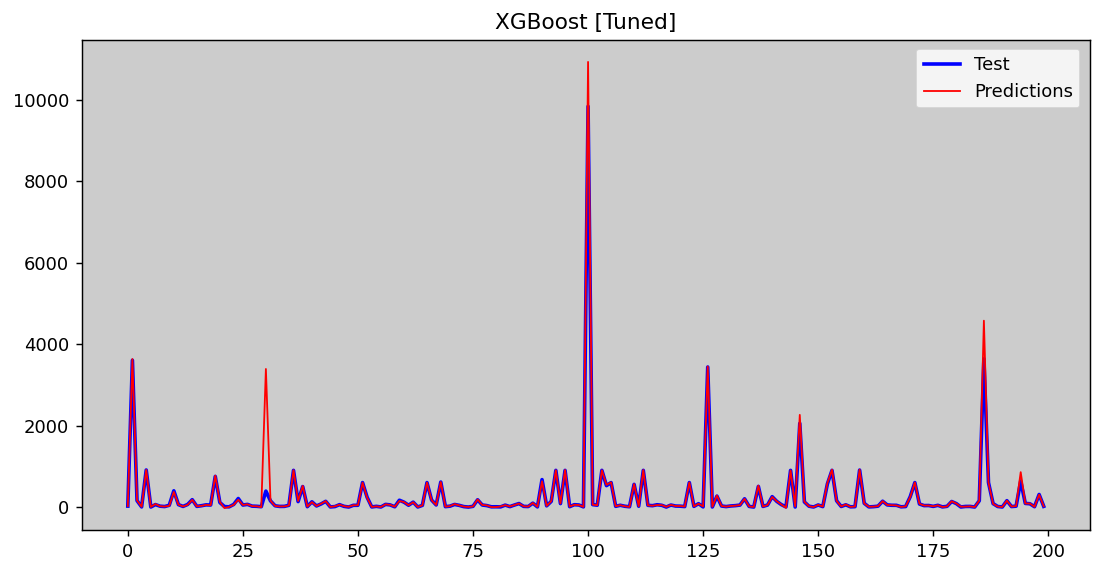

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

test = y_test.to_numpy().tolist()
predictions = pred.tolist()



figure(figsize=(10, 5), dpi=130)

plt.plot(test[0:200],'blue', label='Test',linewidth=2)
plt.plot(predictions[0:200],'red',label='Predictions',linewidth=1)
plt.legend()
ax = plt.axes()
plt.title('XGBoost [Tuned]')
ax.set_facecolor("#cccccc")
plt.plot()

## **n_estimators Vs MAE Plot**

In [ ]:
estimators = [100,200,300,400,500,600,700,800,900,1000]
mae = []

for i in estimators:
  xgb_r = xg.XGBRegressor(objective ='reg:squarederror',colsample_bytree= 0.7,learning_rate= 0.1,subsample= 0.7,n_estimators= i,max_depth= 4,min_child_weight= 1,seed = 123)
  xgb_r.fit(X_train, y_train)
  pred = xgb_r.predict(X_test)
  mae.append(mean_absolute_error(y_test,pred))

NameError: ignored

Text(0, 0.5, 'MAE')

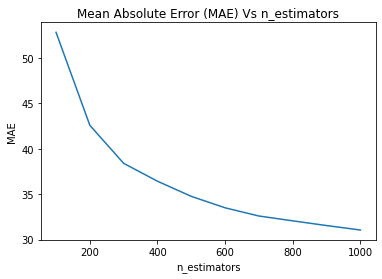

In [ ]:
import matplotlib.pyplot as plt
plt.plot(estimators, mae)
plt.title('Mean Absolute Error (MAE) Vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('MAE')

## **KNN**

In [ ]:
# sample_df

### One hot Encoding for KNN 

In [ ]:
# X_knn = pd.get_dummies(sample_df,columns=['UserID','GroupID','ExecutableID'])

In [ ]:
# X_knn

In [ ]:
# min_max_scaler = preprocessing.MinMaxScaler()
# X_minmax_knn = min_max_scaler.fit_transform(X_knn)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_minmax_knn,y,test_size=0.30,random_state=50)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

#Create KNN Classifier
knn = KNeighborsRegressor(n_neighbors=3)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
knn_pred = knn.predict(X_test)

In [ ]:
knn.score(X_test, y_test)

0.582479564912809

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print('MAE:',mean_absolute_error(y_test,knn_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,knn_pred)))
print('R2 Score:',r2_score(y_test,knn_pred))

MAE: 242.70318518518516
RMSE 2215.7904393324375
R2 Score: 0.582479564912809


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


[]

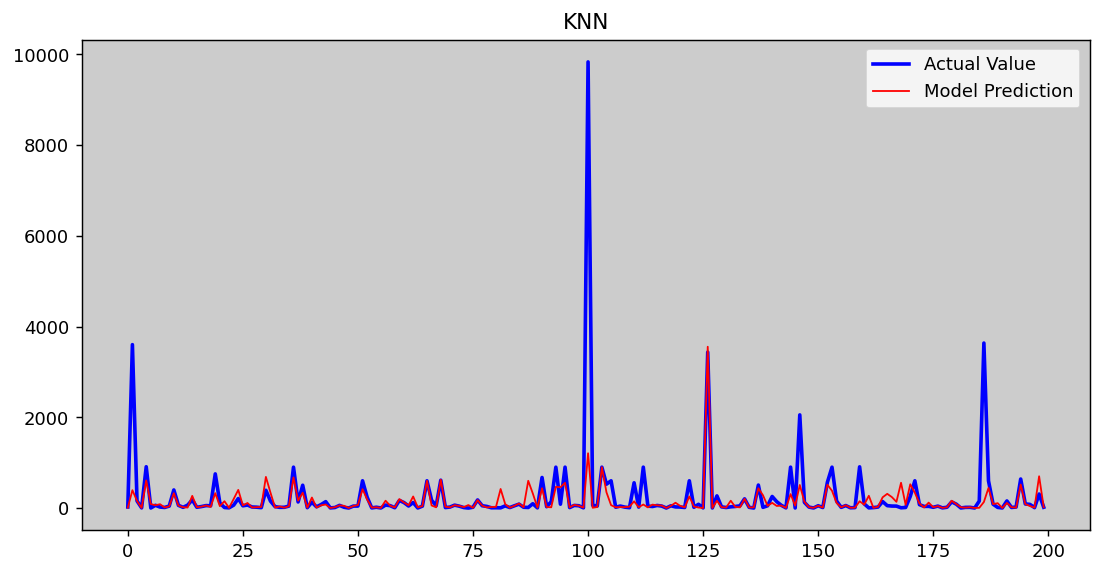

In [ ]:
knn_predList = knn_pred.tolist()
test = y_test.tolist()

figure(figsize=(10, 5), dpi=130)

plt.plot(test[0:200],'blue', label='Actual Value',linewidth=2)
plt.plot(knn_predList[0:200],'red',label='Model Prediction',linewidth=1)
plt.title('KNN')
plt.legend()
ax = plt.axes()
ax.set_facecolor("#cccccc")
plt.plot()

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
# Select an algorithm
from sklearn.model_selection import KFold
algorithm = KNeighborsRegressor()

# Create 3 folds
seed = 13
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Define our candidate hyperparameters
hp_candidates = [{'n_neighbors': [1,2,3,4,5,6], 'weights': ['uniform','distance']}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=algorithm, param_grid=hp_candidates, cv=kfold, scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=13, shuffle=True),
             error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [ ]:
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

-2600.5985904017675
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='distance')
{'n_neighbors': 4, 'weights': 'distance'}


In [ ]:
knn = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='distance')
knn.fit(X_train,y_train)
knn_pred2=  knn.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print('MAE:',mean_absolute_error(y_test,knn_pred2))
print('R2 Score:',r2_score(y_test,knn_pred2))
print("RMSE",np.sqrt(mean_squared_error(y_test,knn_pred2)))

MAE: 203.89958492972633
R2 Score: 0.6719262921159148
RMSE 1964.1539715302092


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


[]

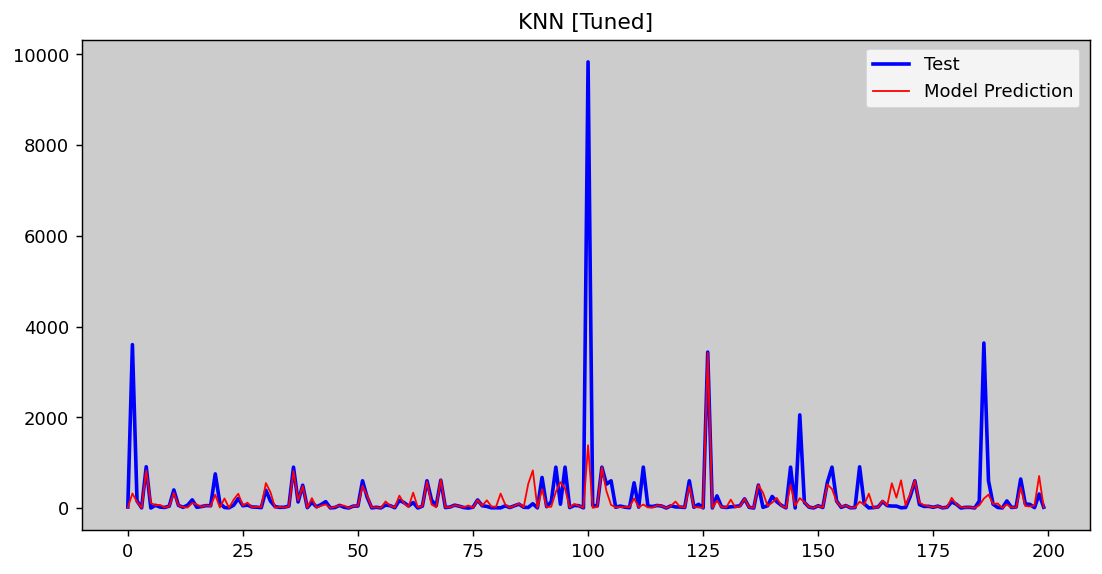

In [ ]:
knn_predList = knn_pred2.tolist()
test = y_test.tolist()

figure(figsize=(10, 5), dpi=130)

plt.plot(test[0:200],'blue', label='Test',linewidth=2)
plt.plot(knn_predList[0:200],'red',label='Model Prediction',linewidth=1)
plt.title('KNN [Tuned]')
plt.legend()
ax = plt.axes()
ax.set_facecolor("#cccccc")
plt.plot()

# **KNN of Filtered Data**

In [ ]:
featureScores.sort_values(by='Score',ascending=False)

,Feature,Score
3,UsedCPUTime,4268.762900
4,UsedMemory,2655.095158
6,ReqTime,1928.216371
8,UserID,904.915663
9,GroupID,809.545198
0,SubmitTime,698.139212
2,NProc,510.761133
5,ReqNProcs,510.761133
12,OrigSiteID,464.693115
13,LastRunSiteID,464.693115


In [ ]:
X.head()



,SubmitTime,WaitTime,NProc,UsedCPUTime,UsedMemory,ReqNProcs,ReqTime,UserID,GroupID,OrigSiteID,LastRunSiteID,JobStructure
18638,1118226329,265,8,0.002500,1196.544,8,960.0,208.216495,163.703850,338.504008,338.504008,390.053283
544751,1119848466,1001,1,56.000000,39788.544,1,900.0,123.893805,360.649792,261.542105,261.542105,390.063011
756710,1161894982,3,2,0.150000,15648.768,2,360.0,264.907277,360.652386,208.783524,208.783524,390.064227
660880,1124929775,6,4,0.055000,9097.216,4,180.0,264.896564,360.647826,208.768451,208.768451,390.062090
558088,1122909406,3,12,0.021667,2831.360,12,900.0,46.452314,163.796150,261.572281,261.572281,390.066180


In [ ]:
X_knn = X.drop(['OrigSiteID','LastRunSiteID','JobStructure','ReqNProcs'],axis=1)

In [ ]:
X_knn.shape

(30000, 7)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
X_minmax_knn = min_max_scaler.fit_transform(X_knn)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax_knn,y,test_size=0.30,random_state=50)

In [ ]:
knn = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='distance')
knn.fit(X_train,y_train)
knn_pred3=  knn.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print('MAE:',mean_absolute_error(y_test,knn_pred3))
print('R2 Score:',r2_score(y_test,knn_pred3))
print("RMSE",np.sqrt(mean_squared_error(y_test,knn_pred3)))

MAE: 191.00563098256004
R2 Score: 0.7801314098266781
RMSE 1607.9458227456505


In [ ]:
knn_predList = knn_pred3.tolist()
test = y_test.tolist()

figure(figsize=(10, 5), dpi=130)

plt.plot(test[0:200],'blue', label='Test',linewidth=2)
plt.plot(knn_predList[0:200],'red',label='Model Prediction',linewidth=1)
plt.title('KNN [Tuned]')
plt.legend()
ax = plt.axes()
ax.set_facecolor("#cccccc")
plt.plot()

NameError: ignored

# **Decision Tree Regressor**

In [ ]:
regressor = DecisionTreeRegressor(random_state=0)

regressor.fit(X_train,y_train)

dtree_pred = regressor.predict(X_test)

In [ ]:
print('MAE:',mean_absolute_error(y_test,dtree_pred))
print('R2 Score:',r2_score(y_test,dtree_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,dtree_pred)))

MAE: 21.652444444444445
R2 Score: 0.943451095203839
RMSE 815.4585958560714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


[]

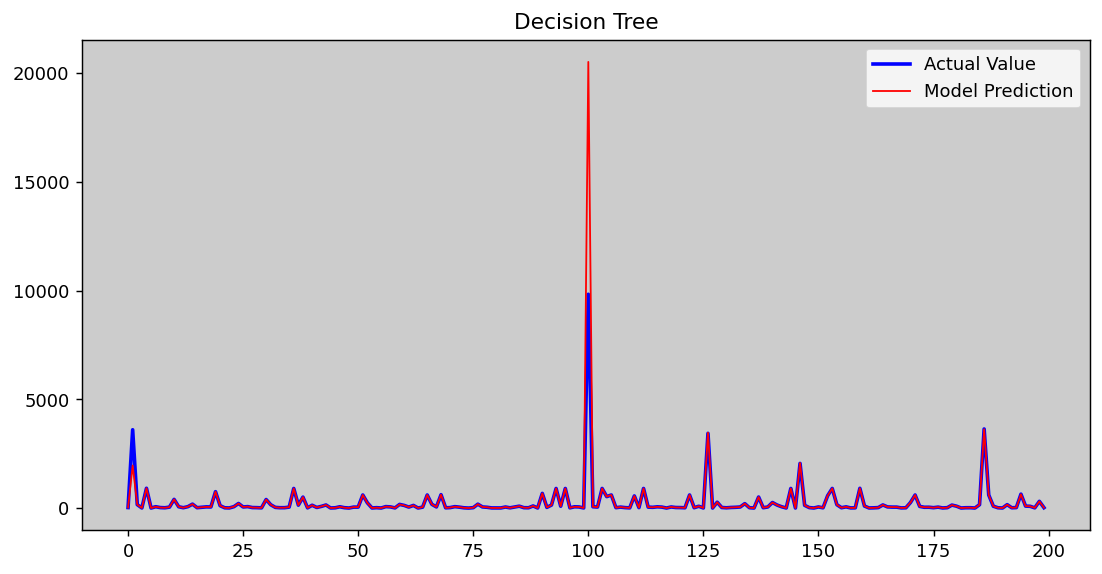

In [ ]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

dtree_predList = dtree_pred.tolist()
test = y_test.tolist()

figure(figsize=(10, 5), dpi=130)

plt.plot(test[0:200],'blue', label='Actual Value',linewidth=2)
plt.plot(dtree_predList[0:200],'red',label='Model Prediction',linewidth=1)
plt.legend()
ax = plt.axes()
plt.title('Decision Tree')
ax.set_facecolor("#cccccc")
plt.plot()

In [ ]:
print('MAE:',mean_absolute_error(y_test,dtree_pred))
print('R2 Score:',r2_score(y_test,dtree_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,dtree_pred)))

MAE: 96.62730605541601
R2 Score: 0.9612420685697303
RMSE 675.1031135803001


# Decision Tree Param Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
    'max_depth': [2,3,4,5,6,7,8,9,10],
    'min_samples_leaf': [3,5,7,9,10],
    'min_samples_split': [2, 3, 50, 100],
    'max_features': ['log2', 'sqrt','auto'],

         
}

In [ ]:
dt = DecisionTreeRegressor(random_state=0)

In [ ]:
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "neg_root_mean_squared_error")

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:   42.5s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=0, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['log2', 'sqrt', 'auto'],
                         'min_samples_leaf': [3, 5, 7, 9, 10],
       

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_params_)

-701.317077710493
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')
{'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2}


In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()


dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
regressor = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

regressor.fit(X_train,y_train)

dtree_pred = regressor.predict(X_test)

In [ ]:
print('MAE:',mean_absolute_error(y_test,dtree_pred))
print('R2 Score:',r2_score(y_test,dtree_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,dtree_pred)))

MAE: 31.182193914191494
R2 Score: 0.972332708868944
RMSE 570.3916194254184


# **Random Forests**

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_minmax,y,test_size=0.30,random_state=50)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10)

rf.fit(X_train, y_train);

rf_pred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print('MAE:',mean_absolute_error(y_test,rf_pred))
print('R2 Score:',r2_score(y_test,rf_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,rf_pred)))

MAE: 14.150455555555554
R2 Score: 0.9927604079099374
RMSE 291.77418482068936


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


[]

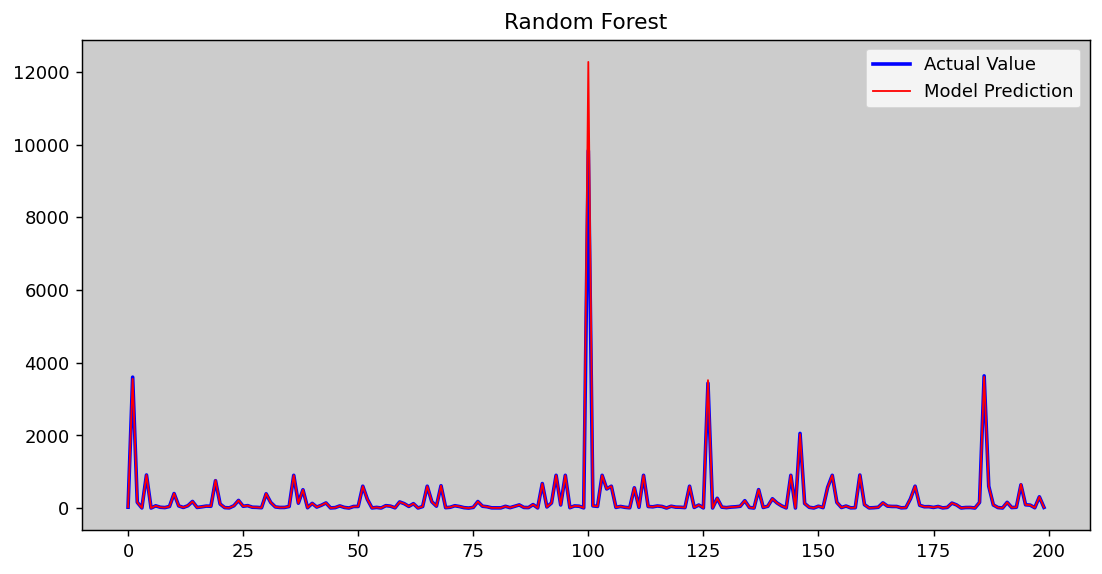

In [ ]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

rf_predList = rf_pred.tolist()
test = y_test.tolist()

figure(figsize=(10, 5), dpi=130)

plt.plot(test[0:200],'blue', label='Actual Value',linewidth=2)
plt.plot(rf_predList [0:200],'red',label='Model Prediction',linewidth=1)
plt.legend()
ax = plt.axes()
plt.title('Random Forest')
ax.set_facecolor("#cccccc")
plt.plot()

In [ ]:
rf = RandomForestRegressor(n_estimators=1)

rf.fit(X_train, y_train);

rf_pred = rf.predict(X_test)

NameError: ignored

In [ ]:
print('MAE:',mean_absolute_error(y_test,rf_pred))
print('R2 Score:',r2_score(y_test,rf_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,rf_pred)))

MAE: 43.43533333333333
R2 Score: 0.927989560417511
RMSE 920.2112681335738


In [ ]:
estimators = list(range(10,100,5))

In [ ]:
estimators

[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [ ]:
# estimators = [10,20,30,40,50,60,70,80,90,100]
mae = []
rmse = []

for i in estimators:
  rf = RandomForestRegressor(n_estimators=i,random_state=0)

  rf.fit(X_train, y_train);

  rf_pred = rf.predict(X_test)
  mae.append(mean_absolute_error(y_test,rf_pred))
  rmse.append(np.sqrt(mean_squared_error(y_test,rf_pred)))

Text(0, 0.5, 'MAE')

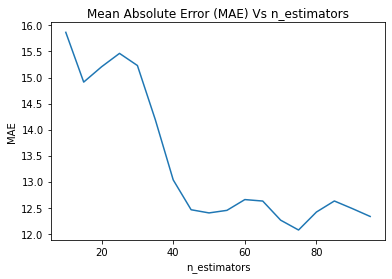

In [ ]:
import matplotlib.pyplot as plt
plt.plot(estimators, mae)
plt.title('Mean Absolute Error (MAE) Vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('MAE')

Text(0, 0.5, 'RMSE')

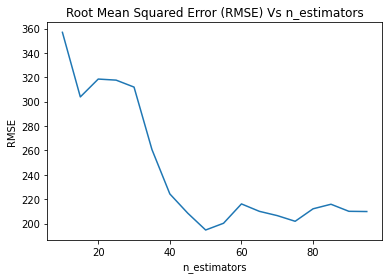

In [ ]:
import matplotlib.pyplot as plt
plt.plot(estimators, rmse)
plt.title('Root Mean Squared Error (RMSE) Vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

In [ ]:
rf = RandomForestRegressor(n_estimators=55 , random_state = 0)
rf.fit(X_train, y_train);
rf_pred = rf.predict(X_test)

In [ ]:
print('MAE:',mean_absolute_error(y_test,rf_pred))
print('R2 Score:',r2_score(y_test,rf_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,rf_pred)))

MAE: 12.45070505050505
R2 Score: 0.9965891260709373
RMSE 200.2731135831246


In [ ]:
minMae = min(mae)
minRmse = min(rmse)
indexMae = mae.index(minMae)
indexRmse = rmse.index(minRmse)
print(minMae)
print(maxRmse)

print(indexMae)
print(indexRmse)


10.544225396825398
181.6880051914018
12
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


[]

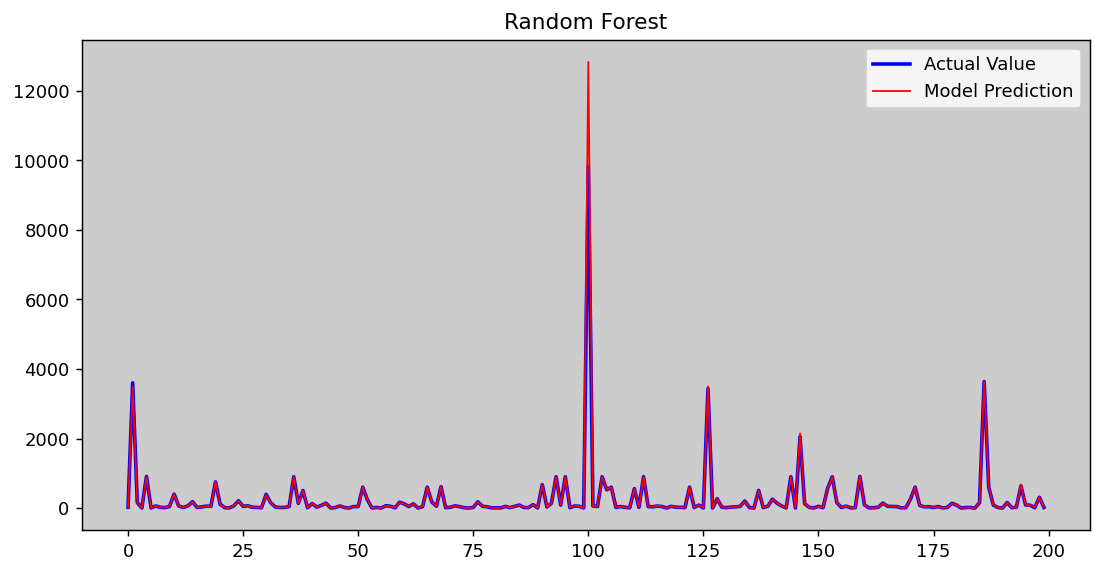

In [ ]:

rf_predList = rf_pred.tolist()
test = y_test.tolist()

figure(figsize=(10, 5), dpi=130)

plt.plot(test[0:200],'blue', label='Actual Value',linewidth=2)
plt.plot(rf_predList [0:200],'red',label='Model Prediction',linewidth=1)
plt.legend()
ax = plt.axes()
plt.title('Random Forest')
ax.set_facecolor("#cccccc")
plt.plot()